In [1]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
# IMAGE PROCESS
import cv2
# MACHINE LEARNING
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use("dark_background")

# Pre Processing

To make the 227 x 227 pixel images compatible with quantum computing, we apply a threshold and downsample the image to be 8 x 8 pixels.


We have modified the preprocessing from: https://www.kaggle.com/brsdincer/surface-crack-detection-end-to-end-process by Baris Dincer.

In [2]:
Surface_Data = Path("crack_dataset")

In [3]:
Surface_JPG_Path = list(Surface_Data.glob(r"*/*.jpg"))

In [4]:
Surface_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Surface_JPG_Path))

TO SERIES

In [5]:
Surface_JPG_Path_Series = pd.Series(Surface_JPG_Path,name="JPG").astype(str)
Surface_Labels_Series = pd.Series(Surface_Labels,name="CATEGORY")

TO DATAFRAME

In [6]:
Main_Surface_Data = pd.concat([Surface_JPG_Path_Series,Surface_Labels_Series],axis=1)

In [7]:
print(Main_Surface_Data.head(-1))

                                      JPG  CATEGORY
0      crack_dataset/Positive/16679_1.jpg  Positive
1        crack_dataset/Positive/04354.jpg  Positive
2        crack_dataset/Positive/02725.jpg  Positive
3      crack_dataset/Positive/11369_1.jpg  Positive
4        crack_dataset/Positive/19463.jpg  Positive
...                                   ...       ...
39994    crack_dataset/Negative/09669.jpg  Negative
39995    crack_dataset/Negative/11026.jpg  Negative
39996    crack_dataset/Negative/05053.jpg  Negative
39997    crack_dataset/Negative/15240.jpg  Negative
39998    crack_dataset/Negative/03422.jpg  Negative

[39999 rows x 2 columns]


TO SHUFFLE

In [8]:
Main_Surface_Data = Main_Surface_Data.sample(frac=1).reset_index(drop=True)

In [9]:
print(Main_Surface_Data.head(-1))

                                      JPG  CATEGORY
0        crack_dataset/Negative/06881.jpg  Negative
1        crack_dataset/Positive/01226.jpg  Positive
2        crack_dataset/Negative/04640.jpg  Negative
3      crack_dataset/Positive/14413_1.jpg  Positive
4        crack_dataset/Negative/09942.jpg  Negative
...                                   ...       ...
39994    crack_dataset/Positive/00931.jpg  Positive
39995    crack_dataset/Positive/19417.jpg  Positive
39996  crack_dataset/Positive/10024_1.jpg  Positive
39997    crack_dataset/Negative/18820.jpg  Negative
39998    crack_dataset/Positive/08143.jpg  Positive

[39999 rows x 2 columns]


# VISUALIZATION

LABELS

In [10]:
Positive_Surface = Main_Surface_Data[Main_Surface_Data["CATEGORY"] == "Positive"]
Negative_Surface = Main_Surface_Data[Main_Surface_Data["CATEGORY"] == "Negative"]

Positive_Surface = Positive_Surface.reset_index()
Negative_Surface = Negative_Surface.reset_index()

In [11]:
def simple_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    plt.xlabel(Reading_Img.shape)
    plt.ylabel(Reading_Img.size)
    plt.imshow(Reading_Img)


In [12]:
def greyscale_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.IMREAD_GRAYSCALE)
    
    plt.xlabel(Reading_Img.shape)
    plt.ylabel(Reading_Img.size)
    plt.imshow(Reading_Img)


In [13]:
def threshold_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    _,Threshold_Img = cv2.threshold(Reading_Img,130,255,cv2.THRESH_BINARY_INV)
    
    plt.xlabel(Threshold_Img.shape)
    plt.ylabel(Threshold_Img.size)
    plt.imshow(Threshold_Img)

## SIMPLE VISION

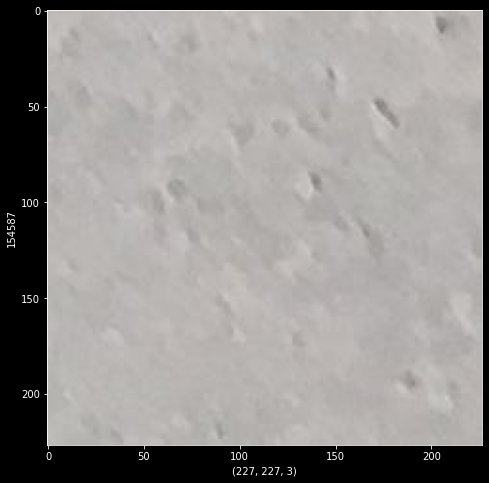

In [14]:
simple_vision(Main_Surface_Data["JPG"][4])

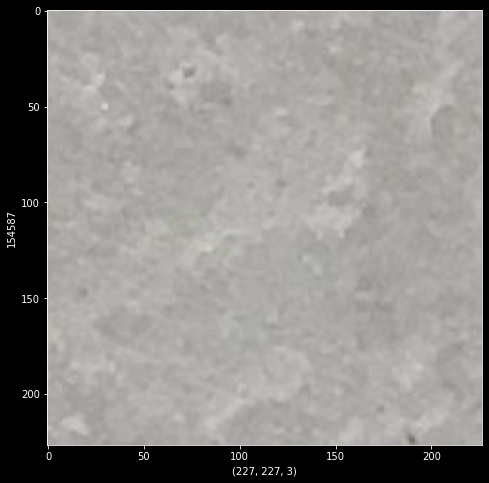

In [15]:


simple_vision(Main_Surface_Data["JPG"][2])



### Positive Surfaces

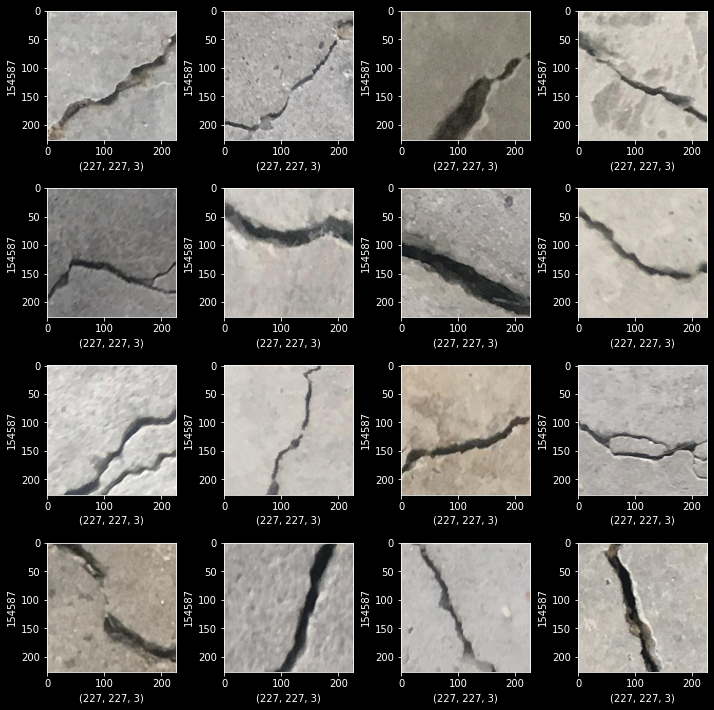

In [16]:
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["JPG"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

### Negative Surfaces

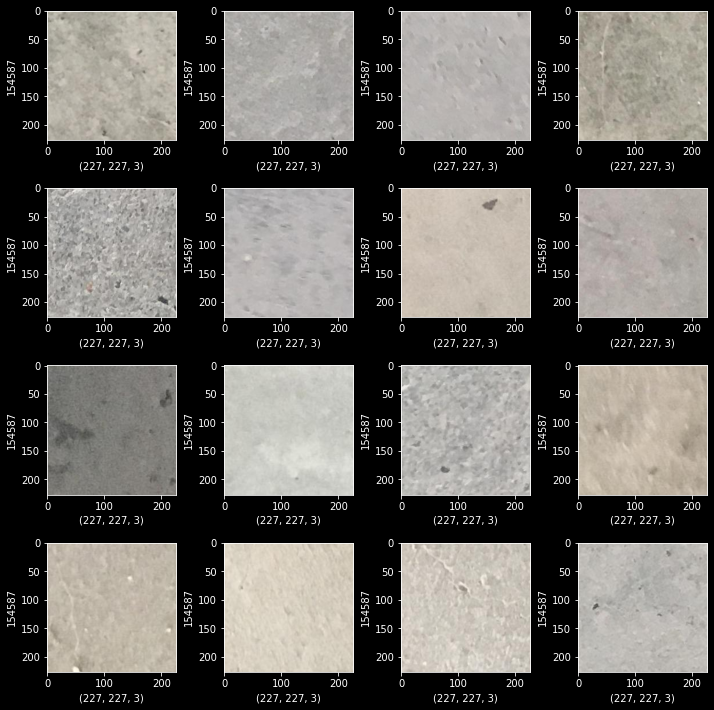

In [17]:
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Negative_Surface["JPG"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

## THRESHOLD VISION

We'll use threshold vision.

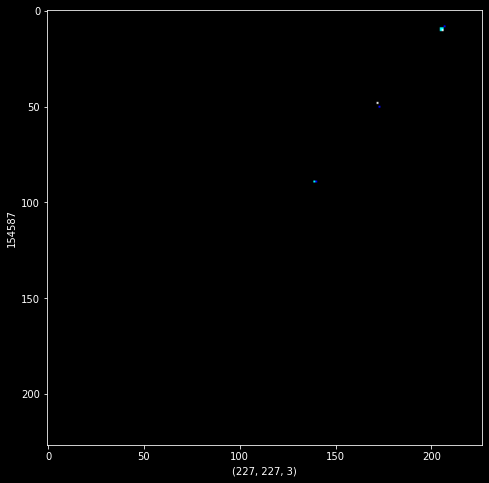

In [18]:
threshold_vision(Main_Surface_Data["JPG"][4])

### Positive Surfaces

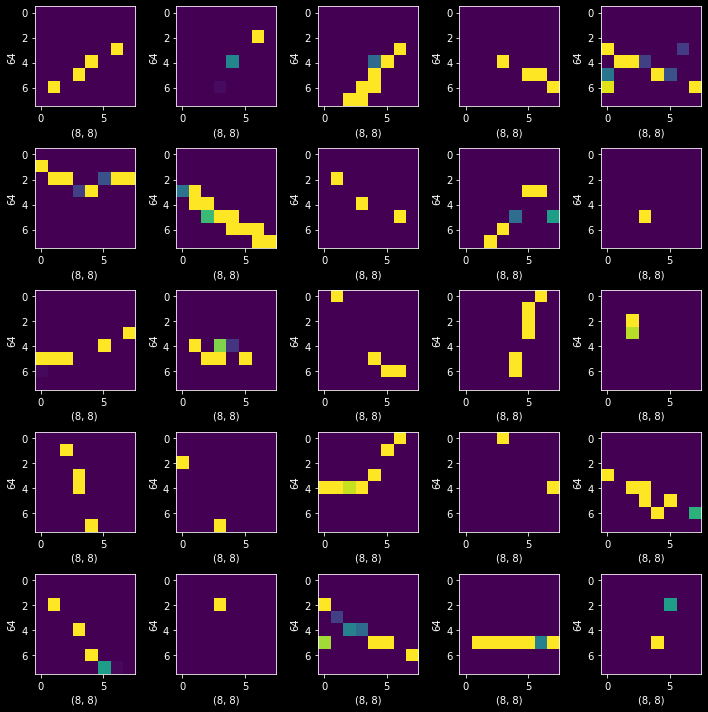

In [19]:
figure,axis = plt.subplots(5,5,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["JPG"][indexing], cv2.IMREAD_GRAYSCALE)
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)

    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

### Negative Surfaces

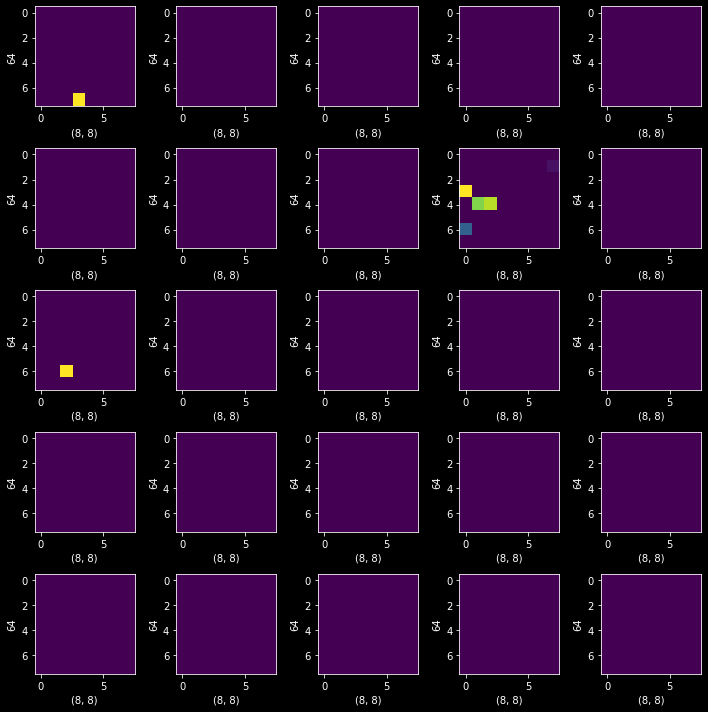

In [20]:
figure,axis = plt.subplots(5,5,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    Reading_Img = cv2.imread(Negative_Surface["JPG"][indexing], cv2.IMREAD_GRAYSCALE)
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)

    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

We note approximately 5% of the images as having contradicting labels when downsampled.

We could follow in the footsteps of Farhi et al. to clean the data further we can discard all the positive and negative images that are misclassified by the downsampling.

In [25]:
def normalize_data(data):
    #Create Array of pixel value
    if not np.any(data):
        # we have to make sure it is normalizable.
        data = data + 0.001
    arr_data = data.flatten()/max(data.flatten())
    encoding_data = np.array([np.round(x,6) for x in arr_data])
    sum_const =  np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm = encoding_data/sum_const
    return encoding_norm


In [26]:
normalize_data(np.array([0,0]))

array([0.70710678, 0.70710678])

In [27]:
def preprocess_image(img_path: str) -> np.ndarray:
    """
    Applies a threshold, resize, then normalize.
    img_path: str =  image file path
    """
    # read image
    Reading_Img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # apply threshold
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)
    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    # normalize image
    Threshold_Img = normalize_data(Threshold_Img)
    return Threshold_Img

We will apply this to both the negative and positive surface datasets.


In [28]:
Main_Surface_Data['Image_Array']=Main_Surface_Data['JPG'].apply(preprocess_image)

We will used the resized arrays as our training feature and the categories as our targets.

In [29]:
X = Main_Surface_Data['Image_Array']
Y = Main_Surface_Data['CATEGORY']

Split the data into test and training sets

In [30]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.3, random_state=42)

In [31]:
testX = np.array([tf.convert_to_tensor(image_array,dtype=np.float32) for image_array in testX])
trainX = np.array([tf.convert_to_tensor(image_array,dtype=np.float32) for image_array in trainX])

2021-09-23 03:34:29.875670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
le = LabelEncoder()
le.fit(["Positive", "Negative"])

LabelEncoder()

In [35]:
testy = le.transform(testy)
trainy = le.transform(trainy)

In [36]:
trainy = tf.one_hot(trainy, depth=1)
testy = tf.one_hot(testy, depth=1)

In [45]:
n_qubits = 6
layers = 1
data_dimension = 2
dev = qml.device("braket.local.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(weights, inputs=None):
    inputs = normalize_data(inputs.numpy())
    inputs = tf.convert_to_tensor(inputs)
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [46]:
weight_shapes = {"weights": (layers,n_qubits,3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64,activation='relu',input_dim=64, trainable=False))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 6)                 0 (unused)
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
Total params: 4,174
Trainable params: 14
Non-trainable params: 4,160
_________________________________________________________________


In [48]:
history = model.fit(trainX[:1000], trainy[:1000], validation_data=(testX[:1000], testy[:1000]), epochs=10, batch_size=10,verbose=1)

Epoch 1/10
100/100 [==============================] - 1615s 16s/step - loss: 0.5747 - accuracy: 0.7440 - val_loss: 0.4659 - val_accuracy: 0.8370
Epoch 2/10
100/100 [==============================] - 825s 8s/step - loss: 0.4031 - accuracy: 0.8830 - val_loss: 0.3519 - val_accuracy: 0.8880
Epoch 3/10
100/100 [==============================] - 821s 8s/step - loss: 0.3304 - accuracy: 0.9050 - val_loss: 0.3003 - val_accuracy: 0.9190
Epoch 4/10
100/100 [==============================] - 828s 8s/step - loss: 0.2947 - accuracy: 0.9220 - val_loss: 0.2703 - val_accuracy: 0.9200
Epoch 5/10
100/100 [==============================] - 822s 8s/step - loss: 0.2734 - accuracy: 0.9230 - val_loss: 0.2511 - val_accuracy: 0.9370
Epoch 6/10
100/100 [==============================] - 830s 8s/step - loss: 0.2591 - accuracy: 0.9360 - val_loss: 0.2379 - val_accuracy: 0.9430
Epoch 7/10
100/100 [==============================] - 827s 8s/step - loss: 0.2489 - accuracy: 0.9430 - val_loss: 0.2329 - val_accuracy: 0.94

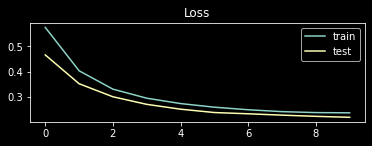

In [49]:

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

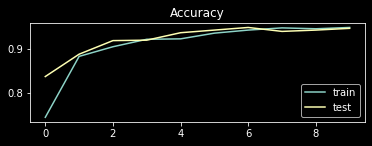

In [50]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [51]:
predy = model.predict(testX[2000:])

In [52]:
from sklearn.metrics import multilabel_confusion_matrix
rounded_labels_pred=np.argmax(predy, axis=1)

rounded_labels_real=testy.numpy()[2000:]

/Users/rickyyoung/opt/anaconda3/envs/qBraid/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass display_labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


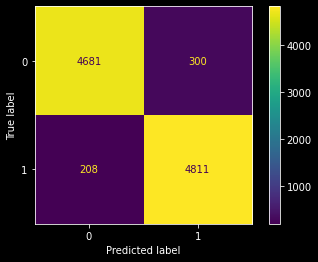

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(rounded_labels_real, rounded_labels_pred)

cm_display = ConfusionMatrixDisplay(cm, [0,1]).plot()